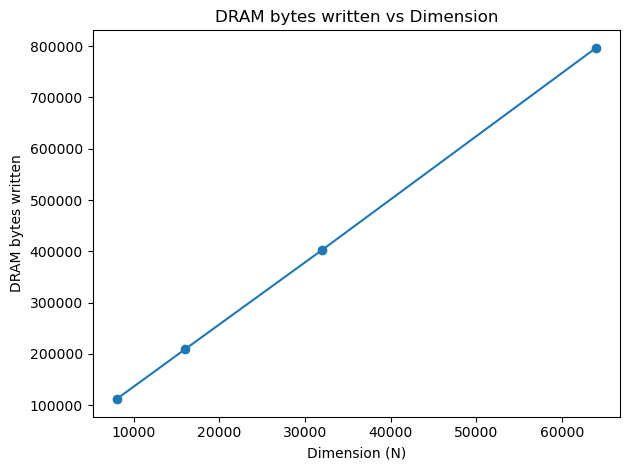

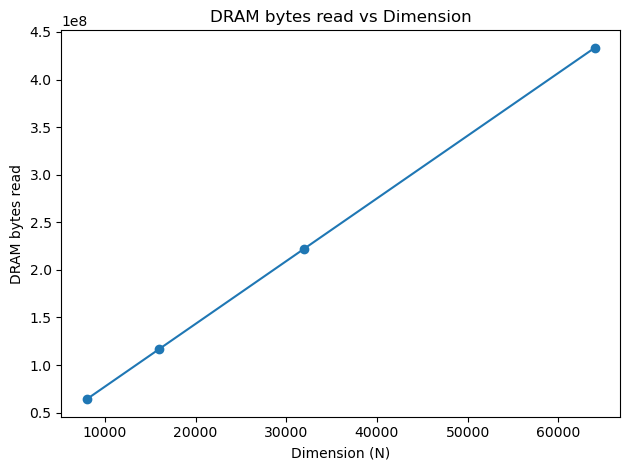

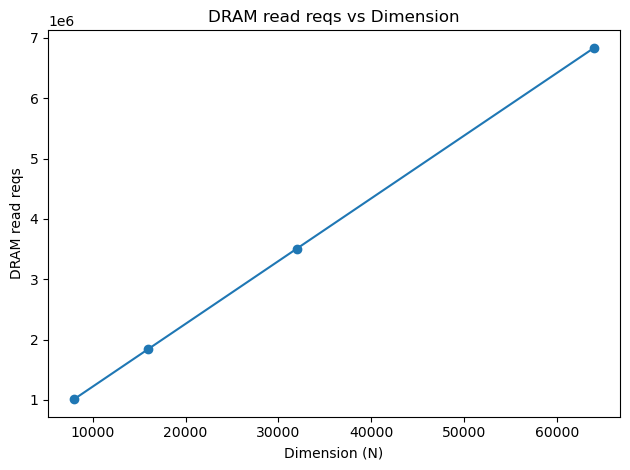

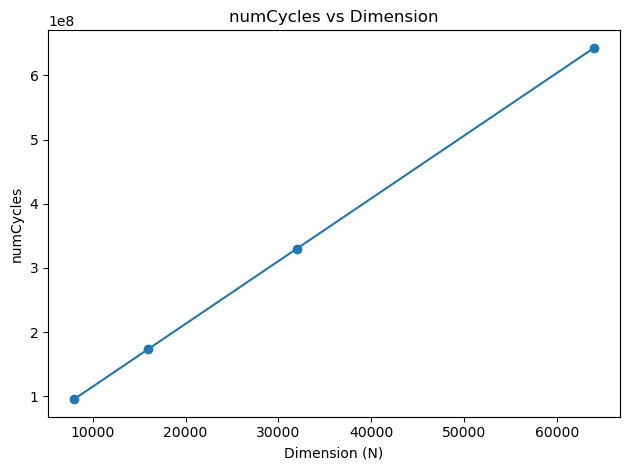

(['results/softmax_plots/DRAM_bytes_written.png',
  'results/softmax_plots/DRAM_bytes_read.png',
  'results/softmax_plots/DRAM_read_reqs.png',
  'results/softmax_plots/numCycles.png'],
 'results/softmax_plots/chosen_metrics.txt')

In [2]:
# Analyze softmax_stats.csv and plot 4 significant metrics (one chart each)
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

csv_path = Path("results/softmax_stats.csv")
assert csv_path.exists(), f"CSV not found at {csv_path}"

df = pd.read_csv(csv_path)

# Normalize column names for easier matching (keep original for plotting label)
colmap = {c: c for c in df.columns}

# Ensure 'dimension' is numeric
if 'dimension' not in df.columns:
    # Try to infer from 'file' column of the previous script (N extracted from filename)
    if 'file' in df.columns:
        dims = []
        for name in df['file'].astype(str):
            n = None
            # extract digits after _N or N
            import re
            m = re.search(r"[ _-]N?(\d+)", name)
            if m: n = int(m.group(1))
            dims.append(n)
        df['dimension'] = dims
    else:
        raise RuntimeError("No 'dimension' column and cannot infer from 'file'.")

df = df.dropna(subset=['dimension']).copy()
df['dimension'] = df['dimension'].astype(int)

# Candidate metrics likely present in gem5 stats
candidate_aliases = {
    'simSeconds': ['simSeconds'],
    'simInsts': ['simInsts'],
    'numCycles': ['numCycles', 'board.processor.cores.core.numCycles'],
    'IPC': ['IPC', 'board.processor.cores.core.ipc'],
    'DRAM bytes read': [
        'DRAM bytes read',
        'board.memory.mem_ctrl.dram.dramBytesRead',
        'board.memory.mem_ctrl.dramBytesRead',
        'board.memory.mem_ctrl.dram.drambytesread'
    ],
    'DRAM read reqs': [
        'DRAM read reqs',
        'board.memory.mem_ctrl.readReqs',
        'board.memory.mem_ctrl.dram.numReads::total',
        'board.memory.mem_ctrl.dram.readReqs'
    ],
    'DRAM bytes written': [
        'DRAM bytes written',
        'board.memory.mem_ctrl.dram.dramBytesWritten',
        'board.memory.mem_ctrl.dramBytesWritten'
    ],
    'hostSeconds': ['hostSeconds'],
}

# Map canonical metric -> actual column name found in CSV
metric_cols = {}
for canon, aliases in candidate_aliases.items():
    for a in aliases:
        if a in df.columns:
            metric_cols[canon] = a
            break

# If fewer than 4 found, keep only those present
available = {m: c for m, c in metric_cols.items()}

# Rank metrics by "significance": variance across dimensions (higher is better)
sig_rank = []
for m, col in available.items():
    try:
        # numericize
        vals = pd.to_numeric(df[col], errors="coerce")
        if vals.notna().sum() >= 2:
            # compute variance in log-space when possible (to avoid dominance by scale)
            v = vals[vals > 0]
            score = v.apply(np.log).var() if (v.size >= 2) else vals.var()
            sig_rank.append((m, col, score if not math.isnan(score) else 0.0))
    except Exception:
        pass

sig_rank.sort(key=lambda x: x[2], reverse=True)

# Choose top 4 significant metrics (fall back if fewer)
chosen = [(m, col) for m, col, _ in sig_rank[:4]]
if len(chosen) < 4:
    # Fill with whatever is available
    for m, col in available.items():
        if (m, col) not in chosen:
            chosen.append((m, col))
        if len(chosen) == 4:
            break

# Prepare output dir
outdir = Path("results/softmax_plots")
outdir.mkdir(parents=True, exist_ok=True)

# Sort by dimension
df_sorted = df.sort_values('dimension')

# Plot each metric separately
plot_paths = []
for canon, col in chosen:
    fig = plt.figure()
    ax = plt.gca()
    ax.plot(df_sorted['dimension'], pd.to_numeric(df_sorted[col], errors="coerce"), marker='o')
    ax.set_xlabel("Dimension (N)")
    ax.set_ylabel(canon)
    ax.set_title(f"{canon} vs Dimension")
    plt.tight_layout()
    png_path = outdir / f"{canon.replace(' ', '_').replace('/', '_')}.png"
    fig.savefig(png_path, dpi=140, bbox_inches="tight")
    plt.show()
    plot_paths.append(str(png_path))

# Save a small report of which metrics were chosen
report_path = outdir / "chosen_metrics.txt"
with open(report_path, "w") as f:
    f.write("Chosen metrics (canonical -> csv column):\n")
    for canon, col in chosen:
        f.write(f"- {canon} -> {col}\n")

plot_paths, str(report_path)


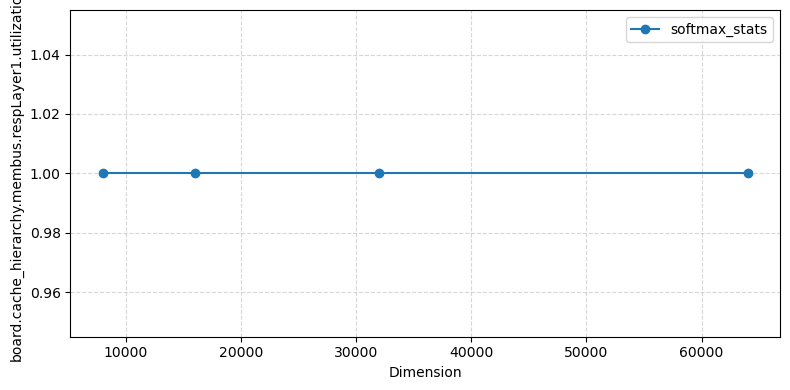

In [12]:
from plot_stats_II import plot_stats

# Plot the metric "full.name.metric" using one or multiple CSV files
plot_stats('board.cache_hierarchy.membus.respLayer1.utilization', 'results/softmax_stats.csv')
# or compare across versions:
#plot_stats('full.name.metric', 'softmax_stats.csv', 'other_version.csv')
